Import all the libraries which are used for importing the dataset and creating the network.

In [22]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import random
import itertools
import time
import gc
import json
from sklearn.metrics import confusion_matrix

Create static variables that will be used later. These variables consists of values such as the rate at which the network learns from the data.

In [2]:
# Number of times to rerun the training dataset
epochs = 1

# How many images to feed through the network each time
batch_size_train = 64
batch_size_test = 1000

# Step size for gradiant decent
learning_rate = 0.01

# Gives the network a chance to jump out of a local minima
momentum = 0.5

# Use a constant seed for randomness so that reruns becomes predictable
random_seed = 1
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.backends.cudnn.enabled = True

#if torch.cuda.is_available():  
#    dev = "cuda:0" 
#else:  
#    dev = "cpu"  
#device = torch.device(dev)

The following code blocks provides the data set with handwritten digits. It converts the images into Pytorch tensors and normalizes the pixels into the range 0 to 1.

In [3]:
training_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True, num_workers=0, pin_memory=True)

test_set = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True, num_workers=0, pin_memory=True)

The following line of code simply outputs the structure of the data. The output here shows that each batch in the training data contains 64 images and that each image has 28x28 pixels dimension.

In [4]:
examples = enumerate(training_set)
_, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

The code block below plots different numbers from the dataset to show numbers and different ways people wrote them down. Each image has a ground truth which simply means what number does the image represent. This is a way to show that everyone has a different handwriting and the network should be capable of recognizing most of the numbers.

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.axis('off')

The following function simply creates and returns a model that contains 3 layers: a 28x28 input layer, a hidden layer of 50 nodes and an output layer of size 10. The LogSoftmax is for normalizing the output vector to a range between 0 and 1.

The following code block trains the network with the handwritten digit data (training_set). It iterates over an n amount of epochs. It also iterates over each batch from the training_set. At each iteration, it adjusts the weights as well as calculating the loss. This allows us to see how accurate is the prediction of each batch. The accuracy is stored in an array which helps to plot the training process of the network.

In [37]:
def train_model(model):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    total = 0
    nr_correct = 0

    accuracies = []
    losses = []
    total_loss = 0
    foo = 0
    for n in range(0, epochs):
        for (batch_index, (images, labels)) in enumerate(training_set):
            (accuracy, loss) = model.fit(images, labels)
            accuracies.append(accuracy)
            total_loss += loss
            foo += images.size(0)
            losses.append(total_loss / foo)
            
    return (accuracies, losses)

The purpose of this function create a test model which can be used to compare to the training model. It is used to check if the model generalized to the other data.

In [7]:
def test_model(model, test_set):
    total = 0
    nr_correct = 0
    
    for images, labels in test_set:
        #images = images.to(device)
        #labels = labels.to(device)
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total = images.size(0)
        nr_correct = torch.sum(predictions == labels).item()
                
    return nr_correct / total

The function within the codeblock below uses the information obtained from the training to plot the rate at which the network learns about the data. The plot contains the amount of training batches and the accuracy of the model during the training.

# CNN Model

In [33]:
class Model(nn.Module):
    def __init__(self, hyper_params):
        super(Model, self).__init__()
        self.hyper_params = hyper_params
        
        layers = []
        for n in self.hyper_params['conv_layers']:
            conv_layer = nn.Conv2d(
                n['in_channels'], 
                n['out_channels'], 
                n['kernel_size']
            )
            layers.append(conv_layer)
            layers.append(self.get_activation_function())
            layers.append(nn.MaxPool2d(2))
        self.conv = nn.Sequential(*layers)
        
        layers = []
        for i in range(len(self.hyper_params['regular_layers']) - 1):
            nr_in = self.hyper_params['regular_layers'][i];
            nr_out = self.hyper_params['regular_layers'][i + 1];
            layers.append(nn.Linear(nr_in, nr_out))
            layers.append(self.get_activation_function())
        
        # The output layer should not have an activation function
        layers.pop()
        
        self.net = nn.Sequential(*layers)
          
        learning_rate = self.hyper_params['learning_rate']
        momentum = self.hyper_params['momentum']
        optimizer = self.hyper_params['optimizer']
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        else:
            raise Exception('Invalid optimizer')
            
        criterion = self.hyper_params['criterion']
        if criterion == 'CrossEntropy':
            self.criterion = nn.CrossEntropyLoss()
        else:
            raise Exception('Invalid criterion')
        
        
    def get_activation_function(self):
        fun = self.hyper_params['activation_function']
        if fun == 'ReLU':
            return nn.ReLU()
        if fun == 'Sigmoid':
            return torch.nn.Sigmoid()
        if fun == 'Swish':
            return Swish()
        
        
    def forward(self, tensor):
        tensor = self.conv(tensor)
        tensor = tensor.reshape(tensor.size(0), -1)
        return self.net(tensor)
    
    
    def fit(self, tensor, labels):
        #tensor = tensor.to(device)
        #labels = labels.to(device)
        result = self(tensor)
        
        self.optimizer.zero_grad()
        loss = self.criterion(result, labels)
        loss.backward()
        self.optimizer.step()
        
        _, predictions = torch.max(result, 1)
        total = tensor.size(0)
        nr_correct = torch.sum(predictions == labels).item()
        
        return (nr_correct / total, loss.item())

This class constructs a model from a dictionary of hyper parameters which allows us to have a variable amount of convolutional layers, hidden layers and different activation functions etc. We've chosen to have a dictionary instead of multiple params to the constructor for an easy way to save, load and print the different model parameters.

Based on @TODO BASE IT ON SOMETHING@ and in order to reduce the amount of different combinations that can be made, we have chosen to only have the convolutional layers in the start of the network and to an activation function and a pooling layer for each convolutional layer.

The forward function describes what steps to make when running the network. We are first running the input tensor through convolutional layers then converting the output to a vector which we feed though the rest of the network. The function gets called when running the network because we are extending nn.Module

The fit function runs the network, then adjust the weights with backpropagation and returns the accuracy for the input tensor.

# Grid search

*SOME GENERAL BLOCK EXPLAINING GRID SEARCH AND OUR PLAN*

@TODO something about why we don't test different batch sizes here?@
@TODO why we will only try one epoch for all models, going through 1000+ combinations takes long time@
@TODO something about missing models with slow learning rate?@
@TODO something about why we have chosen grid search over just random search?@

In [9]:
def hyper_parameter_permutations():
    layer_sizes = [32, 64, 128]
    hidden_layers = [list(n) for n in itertools.permutations(layer_sizes, 1)]\
                  + [[a, b] for (a, b) in itertools.permutations(layer_sizes, 2) if a >= b]
    
    channel_sizes = [4, 8, 16]
    conv_layers = [list(n) for n in itertools.permutations(channel_sizes, 1)]\
                + [[a, b] for (a, b) in itertools.permutations(channel_sizes, 2) if a <= b]
    
    kernel_sizes = [5]
    activation_functions = ['ReLU', 'Sigmoid', 'Swish']
    criterions = ['CrossEntropy']
    
    #Adding momentum directly to the optimizer since it's only used for SGD
    optimizers = [('SGD', 0.1), ('SGD', 0.5), ('SGD', 1.0), 'Adam']
    learning_rates = [0.1, 0.01, 0.001]

    return itertools.product(
        hidden_layers,
        conv_layers,
        kernel_sizes,
        activation_functions,
        criterions,
        optimizers,
        learning_rates
    )

In [10]:
class Swish(nn.Module):
    def forward(self, input_tensor):
        return input_tensor * torch.sigmoid(input_tensor)

The function hyper_parameter_permutations creates a list of all different permutations that we want to test in our search.
As mentioned earlier we based our convolutional network on @TODO BASE IT ON SOMETHING@ and therefore we are using that networks hyper parameters as our starting point. @TODO something about the choice of ranges?@ @TODO something about the limitations that we had to make?@

Hidden layers and convolution layers:
todo

Kernel size:
In order to reduce the amount of combinations we are only testing one kernel size.

We are testing three different activation functions: Sigmoid, ReLU and Swish.
Sigmoid bad
ReLU everyone uses
Swish new from google, supposedly good

Criterions:
Searching through the Internet for good loss functions for classification problems, we only found NLLLoss (The negative log likelihood loss) and Cross Entropy loss that worked with our existing model. Since Cross Entropy Loss is the same as NLLLoss and LogSoftMax @@EXPLAINATION@@ combined we are only using that one.

Optimizers:
todo

Learning rates: 
todo

In [11]:
def permutation_to_dictionary(hidden_layers, channel_sizes, kernel_size, act_fun, criterion, optimizer, learning_rate):
    conv_layers = []
    in_channels = 1
    side_length = 28
    for channel_size in channel_sizes:
        out_channels = channel_size
        conv_layers.append(
            {
                'in_channels': in_channels,
                'out_channels': out_channels,
                'kernel_size': kernel_size
            }
        )
        in_channels = out_channels
    
        side_length -= kernel_size - 1
        side_length //= 2
        
    if type(optimizer) is tuple:
        momentum = optimizer[1]
        optimizer = optimizer[0]
    else:
        momentum = 0
    
    regular_layers = [side_length * side_length * out_channels] + hidden_layers + [10]
    return {
        'conv_layers': conv_layers,
        'regular_layers': regular_layers,
        'activation_function': act_fun,
        'optimizer': optimizer,
        'criterion': criterion,
        'learning_rate': learning_rate,
        'momentum': momentum
    }

This function converts the hyper parameter permutations to the dictionary format that we use to construct the models.

In [12]:
def grid_search():
    gc.collect()
    before = time.time()

    models = []
    
    permutations = list(hyper_parameter_permutations())
    
    print("Searching through {} permutations".format(len(permutations)))

    i = 0
    for n in permutations:
        grid_search_helper(n, models)
        break
        i += 1
        
        if i % 100 == 0:
            print("{} complete, time elapsed: {:.2f} minutes".format(i, (time.time() - before) / 60))
            
        if i % 500 == 0:
            gc.collect()

    models.sort(key=lambda n: n[0], reverse=True)

    after = time.time()
    print("Done, took {:.2f} minutes".format((after - before) / 60))
    
    return models

# Wrapper function that allows the garbage collector to run
def grid_search_helper(permutation, models):
    hyper_params = permutation_to_dictionary(*permutation)
    model = Model(hyper_params)
    model.to(device)
    train_model(model)
    accuracy = test_model(model, test_set)
    models.append((accuracy, model.hyper_params))


Here is the actual search, where we are searching for the model with the highest accuracy by going though all permutations, constructing a model for each, training it and comparing the model to the test set. Then storing the models hyper parameters along with the accuracy in a sorted list from best accuracy to worst. In our first run we ran out of memory so we had to wrap the logic for each model in a separate function so that we could run the garbage collector.

In [13]:
def write_json(params, filename):
    params_json = json.dumps(params)
    f = open(filename, "w")
    f.write(params_json)
    f.close()
    
def read_json(filename):
    f = open(filename, "r")
    params = json.loads(f.read())
    f.close()
    return params

Because we don't want to perform our lengthy grid search multiple times, we have a simple read/write to a json file.

In [36]:
epochs = 1
models = grid_search()
write_json(models, "one_epoch_models.json")

Searching through 1296 permutations


RuntimeError: DataLoader worker (pid(s) 6280, 2008, 2412, 1492) exited unexpectedly

*BLOCK ABOUT RUNNING IT*

In [14]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
           
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # print(cm)

    fig, ax = plt.subplots(figsize = (10, 10))
    im = ax.imshow(cm,cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    x_classes = classes 
    classes.reverse()
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),       
           xticklabels=x_classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right")

    # Loop over data dimensions and create text annotations.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color="white" if cm[i, j] > 500 else "black"
            ax.text(j, i, format(cm[i, j]), ha="center", va="center", color=color)
    
    ax.set_xticks(np.arange(cm.shape[1]+1)-.5)
    ax.set_yticks(np.arange(cm.shape[0]+1)-.5)
    plt.show()

In [38]:
print(read_json("one_epoch_models.json")[:1][0][1])
model = Model(read_json("one_epoch_models.json")[:1][0][1])
(_, total_loss) = train_model(model)

{'conv_layers': [{'in_channels': 1, 'out_channels': 8, 'kernel_size': 5}, {'in_channels': 8, 'out_channels': 16, 'kernel_size': 5}], 'regular_layers': [256, 128, 64, 10], 'activation_function': 'Swish', 'optimizer': 'SGD', 'criterion': 'CrossEntropy', 'learning_rate': 0.1, 'momentum': 0.5}


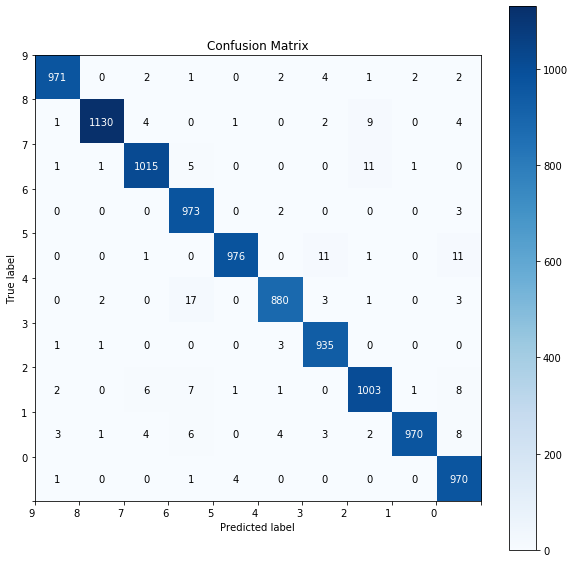

Number Of Images Tested = 10000
0

Model Accuracy = 0.0


In [24]:
correct_count, all_count = 0, 0
predicted_labels = []
actual_labels = []

for images,labels in test_set:
    result = model(images)
    
    _, predictions = torch.max(result, 1)
    predicted_labels = predicted_labels + predictions.tolist()
    actual_labels = actual_labels + labels.tolist()
    all_count += images.size(0)
    
label_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]
plot_confusion_matrix(predicted_labels, actual_labels, label_list)

print("Number Of Images Tested =", all_count)
print(correct_count)
print("\nModel Accuracy =", (correct_count/all_count))

ValueError: x and y must have same first dimension, but have shapes (0,) and (938,)

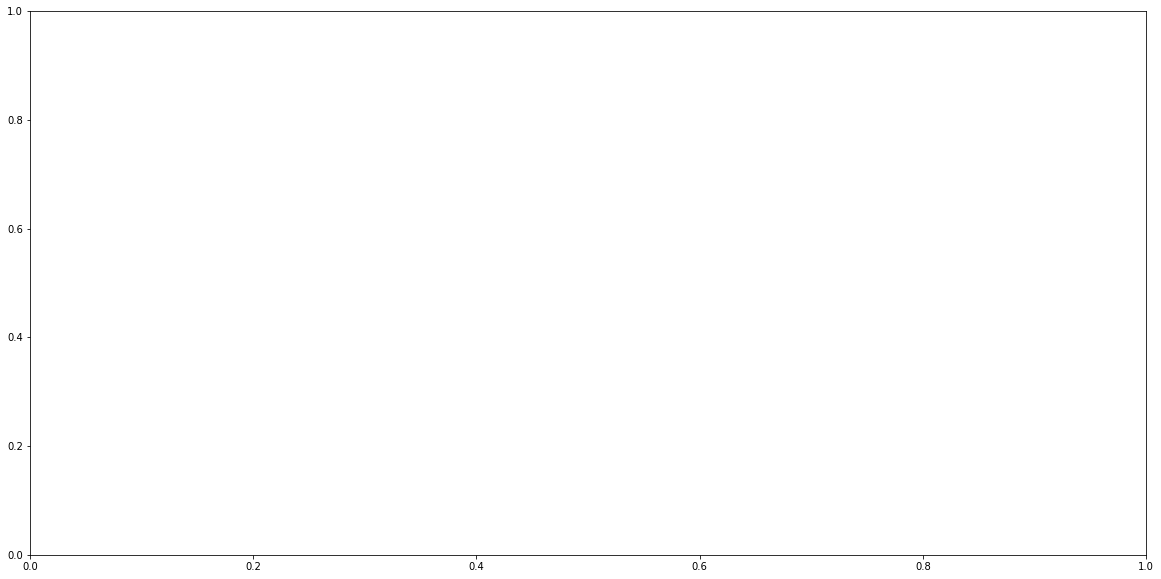

In [39]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, 1), total_loss, label="Train loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()